In [1]:
import numpy as np
import pandas as pd

from gensim.models import FastText
from gensim.test.utils import common_texts
from gensim.utils import tokenize

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence

# PREPARE DATA TO AUTOENCODER

In [2]:
train = pd.read_csv('../../data/interim/cadec/train.csv')
test = pd.read_csv('../../data/interim/cadec/test.csv')

In [3]:
sentences = pd.read_csv('../../data/interim/cadec/test.csv')['text'].apply(
                lambda x: x.lower().split('<SENT>')).explode().apply(lambda x: list(tokenize(x))).to_list()

max_seq_len = 10
embed_dim = 150
nb_words = 3000

ftmodel = FastText(size=embed_dim, window=5, min_count=1)
ftmodel.build_vocab(sentences=sentences)
ftmodel.train(sentences=sentences, total_examples=len(sentences), epochs=10)

In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=nb_words,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False
)

tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

nb_words = min(nb_words, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = ftmodel[word]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
        
word_seq_train = tokenizer.texts_to_sequences(train['term'])
word_seq_test = tokenizer.texts_to_sequences(test['term'])

X_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
X_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

labels = pd.read_csv('../../data/interim/meddra_codes_terms_synonims.csv')
labels = labels['CODE']
meddra_labels = {v:k for k, v in enumerate(labels.unique())}

y_train = train['code'].apply(lambda x: meddra_labels[x]).to_numpy()
y_test = test['code'].apply(lambda x: meddra_labels[x]).to_numpy()

number_of_classes = labels.unique().shape[0]

/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [5]:
import pickle

with open('../../models/encoder/tokenizer.pickle', 'wb') as tok_bin:
    pickle.dump(tokenizer, tok_bin, pickle.HIGHEST_PROTOCOL)
with open('../../models/encoder/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

In [6]:
X_train.shape, X_test.shape

((3520, 10), (881, 10))

# MODEL



In [7]:
import keras
from keras import layers, Model
from keras.utils import to_categorical 


vocab_size = nb_words
src_txt_length = max_seq_len
sum_txt_length = max_seq_len

# encoder input model
inputs = layers.Input(shape=(src_txt_length,))
encoder1 = layers.Embedding(nb_words, embed_dim, input_length=max_seq_len, 
                        weights=[embedding_matrix],trainable=False)(inputs)
encoder2 = layers.Bidirectional(layers.LSTM(256))(encoder1)
encoder3 = layers.Dense(128)(encoder2)
encoder4 = layers.RepeatVector(sum_txt_length)(encoder3)

# decoder output model
decoder1 = layers.LSTM(256, return_sequences=True)(encoder4)
outputs = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))(decoder1)

# tie it together
model = Model(inputs=inputs, outputs=outputs)


optimizer = keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 150)           450000    
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               833536    
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 3000)          771000

In [8]:
earlystopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

history = model.fit(
    X_train, 
    to_categorical(X_train, num_classes=nb_words),
    epochs=500,
    validation_data=(X_test, to_categorical(X_test, num_classes=nb_words)),
    callbacks=[earlystopping]
)

Epoch 1/500
110/110 [==============================] - 9s 49ms/step - loss: 3.1326 - val_loss: 2.0146
Epoch 2/500
110/110 [==============================] - 5s 45ms/step - loss: 1.9452 - val_loss: 1.9729
Epoch 3/500
110/110 [==============================] - 4s 39ms/step - loss: 1.9093 - val_loss: 1.9347
Epoch 4/500
110/110 [==============================] - 4s 40ms/step - loss: 1.8925 - val_loss: 1.8880
Epoch 5/500
110/110 [==============================] - 4s 40ms/step - loss: 1.7926 - val_loss: 1.8443
Epoch 6/500
110/110 [==============================] - 4s 39ms/step - loss: 1.7567 - val_loss: 1.8201
Epoch 7/500
110/110 [==============================] - 4s 40ms/step - loss: 1.7404 - val_loss: 1.7609
Epoch 8/500
110/110 [==============================] - 4s 39ms/step - loss: 1.6869 - val_loss: 1.7708
Epoch 9/500
110/110 [==============================] - 4s 39ms/step - loss: 1.6659 - val_loss: 1.7162
Epoch 10/500
110/110 [==============================] - 4s 40ms/step - loss: 1.625

110/110 [==============================] - 4s 40ms/step - loss: 0.4000 - val_loss: 0.8784
Epoch 81/500
110/110 [==============================] - 5s 41ms/step - loss: 0.3858 - val_loss: 0.9198
Epoch 82/500
110/110 [==============================] - 4s 40ms/step - loss: 0.3998 - val_loss: 0.8869
Epoch 83/500
110/110 [==============================] - 4s 40ms/step - loss: 0.3566 - val_loss: 0.8776
Epoch 84/500
110/110 [==============================] - 4s 40ms/step - loss: 0.3731 - val_loss: 0.8827
Epoch 85/500
110/110 [==============================] - 4s 39ms/step - loss: 0.3723 - val_loss: 0.8769
Epoch 86/500
110/110 [==============================] - 4s 39ms/step - loss: 0.3452 - val_loss: 0.8718
Epoch 87/500
110/110 [==============================] - 4s 38ms/step - loss: 0.3649 - val_loss: 0.8918
Epoch 88/500
110/110 [==============================] - 4s 39ms/step - loss: 0.3434 - val_loss: 0.8772
Epoch 89/500
110/110 [==============================] - 4s 39ms/step - loss: 0.3414 - 

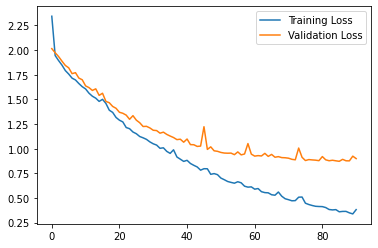

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [10]:
text = ['headache is the strangest thing ever']
tokenized = tokenizer.texts_to_sequences(text)
tokenized = sequence.pad_sequences(tokenized, maxlen=max_seq_len)
tokenizer.sequences_to_texts(tokenized), tokenized

(['headache is the thing ever'],
 array([[  0,   0,   0,   0,   0, 363,  24,   4, 438, 268]], dtype=int32))

In [11]:
import numpy as np
predicted = [np.argmax(i) for i in model.predict(tokenized)[0]]
tokenizer.sequences_to_texts([predicted])

['rotton all to to to']

In [12]:
predicted

[0, 0, 0, 0, 0, 2253, 29, 5, 5, 5]

# Get encoder

In [13]:
encoder = keras.Sequential(model.layers[:4])
encoder.predict(tokenized).shape

(1, 128)

In [14]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 150)           450000    
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               833536    
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
Total params: 1,349,200
Trainable params: 899,200
Non-trainable params: 450,000
_________________________________________________________________


In [15]:
encoder.save('../../models/encoder/encoder_cadec.h5')

In [16]:
encoder_loaded = keras.models.load_model('../../models/encoder/encoder_cadec.h5')

In [17]:
encoder_loaded.predict(tokenized).shape

(1, 128)

In [18]:
text = pd.DataFrame([
    'sick of this pain my back yeahh',
    'this is second message',
    'this is third message'
])
text

,0
0,sick of this pain my back yeahh
1,this is second message
2,this is third message


In [19]:

tokenized = tokenizer.texts_to_sequences(text[0])
tokenized = sequence.pad_sequences(tokenized, maxlen=max_seq_len)
#pd.DataFrame()
text['vec'] = tokenizer.texts_to_sequences(text[0])
#text['vec'] = text['vec'].apply(lambda toks: encoder_loaded.predict(toks).shape)
text['vec'] = sequence.pad_sequences(text['vec'], maxlen=max_seq_len).tolist()
text['vec'] = text['vec'].apply(lambda seq: encoder_loaded.predict([seq])[0])
text

,0,vec
0,sick of this pain my back yeahh,"[1.7217798, -2.1035154, -1.3880174, -2.6382208..."
1,this is second message,"[1.327511, -5.3665457, -5.434833, -9.064444, 0..."
2,this is third message,"[1.7789334, -5.211913, -5.134136, -8.604033, 0..."


In [20]:
text['vec'].iloc[0].shape

(128,)